# Face Emotion Detection


## Library Imports

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from tensorflow.keras import regularizers as reg
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras import regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, SpatialDropout2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Reading and Splitting

In [4]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# defining dir variables 
root_dir = '/content/drive/MyDrive/Data/'
train_dir = root_dir + 'train/'
valid_dir = root_dir + 'valid/'
test_dir = root_dir + 'test/'

In [6]:
batch_size = 32
img_height = 180 
img_width = 180

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 22992 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Found 5767 files belonging to 7 classes.


## Data Visualization

In [7]:
class_names = train_data.class_names
num_classes = len(class_names)
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


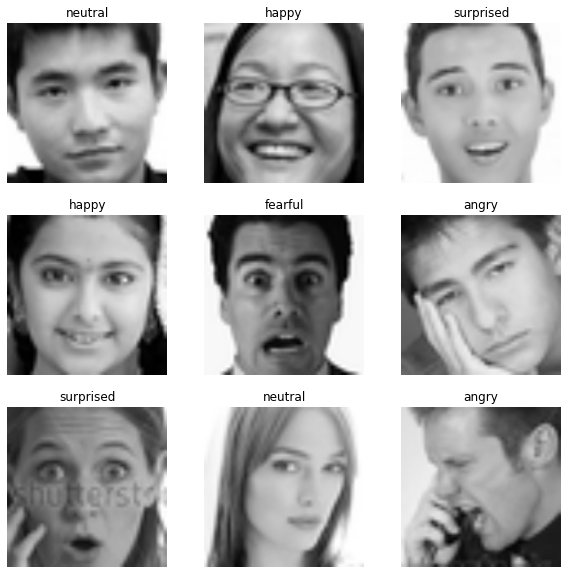

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
target_var = os.listdir(test_dir)
target_var

['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

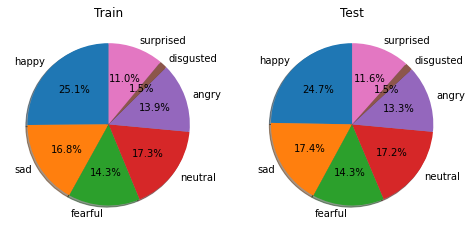

Emotion : happy
	Training : 5772
	 Testing : 1774
	 Validation : 1445
Emotion : sad
	Training : 3864
	 Testing : 1247
	 Validation : 967
Emotion : fearful
	Training : 3279
	 Testing : 1024
	 Validation : 819
Emotion : neutral
	Training : 3972
	 Testing : 1233
	 Validation : 995
Emotion : angry
	Training : 3196
	 Testing : 958
	 Validation : 800
Emotion : disgusted
	Training : 349
	 Testing : 111
	 Validation : 88
Emotion : surprised
	Training : 2537
	 Testing : 831
	 Validation : 635


In [ ]:
x_train = np.array([ len(os.listdir(train_dir+i+'/')) for i in target_var ])
#x_valid = np.array([ len(os.listdir(valid_dir+i+'/')) for i in target_var ])
x_test = np.array([ len(os.listdir(test_dir+i+'/')) for i in target_var ])

label = target_var
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
#axes[2].pie(x_valid, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
#axes[2].set_title('Validation')
plt.show()

for i in target_var:
    print('Emotion : ' + i )
    print('\tTraining : ' + str(len(os.listdir(train_dir+i+'/'))) +'\n\t Testing : ' + str(len(os.listdir(test_dir+i+'/')))+'\n\t Validation : ' + str(len(os.listdir(valid_dir+i+'/'))))

## Data Augmentation

- zoom range (0.2)
- Resize the images (224x224)
- Scaling/Normalization (1 to 255)
- Randomly flip images (Horizontally)
- Randomly rotate images (up to 20°)

In [8]:
data_augmentation = Sequential([
   #zoom_range = 0.2,
    Resizing(224, 224), 
    Rescaling(1./255),
    #RandomFlip("horizontal"),
    #RandomRotation(0.2)
])

## Model Metrics

In [9]:
def plot_model_performance(hist, model_name=None, save=False):
    model_hist = pd.DataFrame(hist.history)
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=model_hist[['accuracy', 'val_accuracy']])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    
    if save and model_name:
        plt.title(f'{model_name} Accuracy Graph')
        plt.savefig(f'Images/{model_name} accuracy graph.png', transparent=True, bbox_inches='tight')

## Model Training

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

## Simple Neural Network Baseline

In [ ]:
sbase_NN = Sequential()
sbase_NN.add(data_augmentation)
sbase_NN.add(Dense(8, activation='relu'))
sbase_NN.add(Flatten())
sbase_NN.add(Dense(7, activation='softmax'))
sbase_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
sbase_NN_hist = sbase_NN.fit(train_data, epochs=4, validation_data=valid_data, verbose=1)

Epoch 1/4
718/718 [==============================] - 32s 43ms/step - loss: 1.8186 - accuracy: 0.2458 - val_loss: 1.8159 - val_accuracy: 0.1829
Epoch 2/4
 41/718 [>.............................] - ETA: 1:08 - loss: 1.8015 - accuracy: 0.2241

In [ ]:
plot_model_performance(sbase_NN_hist,'Simple Baseline NN', save=True)

In [ ]:
train_loss, train_acc = sbase_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = sbase_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

## Neural Network Baseline (NN)

In [ ]:
base_NN = Sequential()
base_NN.add(data_augmentation)
base_NN.add(Dense(4, activation='relu')) 
base_NN.add(Dense(8, activation='relu')) 
base_NN.add(Dense(16,activation='relu')) 
base_NN.add(Dense(32,activation='relu'))
base_NN.add(Dense(16,activation='relu'))
base_NN.add(Dense(8, activation='relu'))
base_NN.add(Flatten())
base_NN.add(Dense(7, activation='softmax'))

base_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
base_NN_hist = base_NN.fit(train_data, epochs=6, validation_data=valid_data, verbose=1)

Epoch 1/6
718/718 [==============================] - 52s 71ms/step - loss: 1.7920 - accuracy: 0.2479 - val_loss: 1.7898 - val_accuracy: 0.2495
Epoch 2/6
718/718 [==============================] - 71s 100ms/step - loss: 1.7751 - accuracy: 0.2623 - val_loss: 1.7770 - val_accuracy: 0.2533
Epoch 3/6
718/718 [==============================] - 66s 91ms/step - loss: 1.7673 - accuracy: 0.2699 - val_loss: 1.7708 - val_accuracy: 0.2584
Epoch 4/6
718/718 [==============================] - 68s 95ms/step - loss: 1.7623 - accuracy: 0.2692 - val_loss: 1.7681 - val_accuracy: 0.2572
Epoch 5/6
718/718 [==============================] - 71s 98ms/step - loss: 1.7622 - accuracy: 0.2711 - val_loss: 1.7596 - val_accuracy: 0.2619
Epoch 6/6
718/718 [==============================] - 64s 90ms/step - loss: 1.7588 - accuracy: 0.2711 - val_loss: 1.7599 - val_accuracy: 0.2617


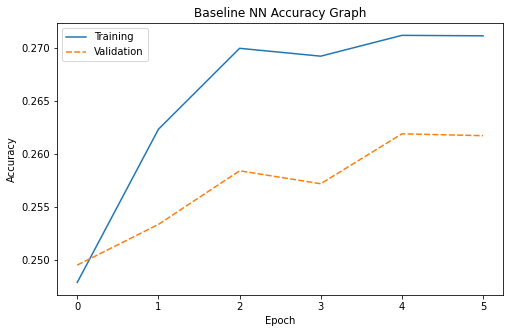

In [ ]:
plot_model_performance(base_NN_hist, 'Baseline NN', save=True)

In [ ]:
train_loss, train_acc = base_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

180/180 [==============================] - 12s 64ms/step - loss: 1.7599 - accuracy: 0.2617


Training Accuracy:	26.6440212726593
Training Loss:		1.752709150314331

Validation Accuracy:	26.1701762676239
Validation Loss:	1.7598847150802612

Train/Validation Diff:	 0.4738450050354004


## Convolutional Neural Network Baseline (CNN)

In [ ]:
base_CNN = Sequential()
base_CNN.add(data_augmentation)
base_CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())
base_CNN.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())
base_CNN.add(Flatten())
base_CNN.add(Dense(7, activation='softmax'))
base_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
base_CNN_hist = base_CNN.fit(train_data, epochs=5, validation_data=valid_data, verbose=1)

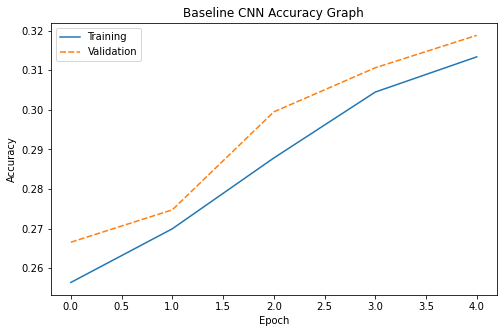

In [ ]:
plot_model_performance(base_CNN_hist, 'Baseline CNN', save=True)

In [ ]:
train_loss, train_acc = base_CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

180/180 [==============================] - 13s 72ms/step - loss: 1.6876 - accuracy: 0.3188


Training Accuracy:	33.17655324935913
Training Loss:		1.6737563610076904

Validation Accuracy:	31.87749981880188
Validation Loss:	1.6876177787780762

Train/Validation Diff:	 1.299053430557251


##  Models

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report , roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [12]:
sgd_opt = SGD(learning_rate=0.001) 
adam_opt = Adam(learning_rate=0.001)

## CNN-v1

In [ ]:
CNN = Sequential()
CNN.add(data_augmentation)
CNN.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Dropout(0.4))


CNN.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Dropout(0.3))

CNN.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Dropout(0.3))

CNN.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Dropout(0.3))

CNN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Dropout(0.2))


CNN.add(Flatten())
CNN.add(Dense(7, activation='softmax'))

CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
CNN_hist = CNN.fit(train_data, epochs=5, validation_data=valid_data, verbose=1)

Epoch 1/5
718/718 [==============================] - 447s 621ms/step - loss: 1.8332 - accuracy: 0.2354 - val_loss: 1.8111 - val_accuracy: 0.2504
Epoch 2/5
718/718 [==============================] - 432s 602ms/step - loss: 1.8115 - accuracy: 0.2521 - val_loss: 1.8022 - val_accuracy: 0.2594
Epoch 3/5
718/718 [==============================] - 440s 612ms/step - loss: 1.8015 - accuracy: 0.2519 - val_loss: 1.7965 - val_accuracy: 0.2610
Epoch 4/5
718/718 [==============================] - 426s 594ms/step - loss: 1.7961 - accuracy: 0.2537 - val_loss: 1.7890 - val_accuracy: 0.2601
Epoch 5/5
718/718 [==============================] - 419s 584ms/step - loss: 1.7924 - accuracy: 0.2549 - val_loss: 1.7887 - val_accuracy: 0.2622


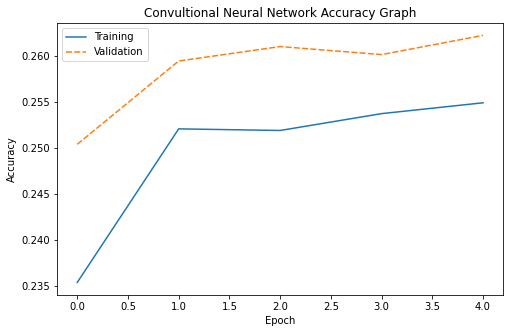

In [ ]:
plot_model_performance(CNN_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

180/180 [==============================] - 33s 185ms/step - loss: 1.7887 - accuracy: 0.2622


Training Accuracy:	26.103997230529785
Training Loss:		1.7867728471755981

Validation Accuracy:	26.22237801551819
Validation Loss:	1.7886983156204224

Train/Validation Diff:	 0.11838078498840332


In [ ]:
#CNN.save('Deliverables/cnn1_model.h5')

## CNN-v2

In [ ]:
CNN2 = Sequential()
CNN2.add(data_augmentation)
CNN2.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
CNN2.add(Dropout(0.1)) 

CNN2.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
CNN2.add(Dropout(0.3))
CNN2.add(MaxPooling2D())


CNN2.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
CNN2.add(Dropout(0.3))

CNN2.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPooling2D())
CNN2.add(Dropout(0.3))

CNN2.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
#CNN2.add(Dropout(0.2))
CNN2.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPooling2D())
#CNN2.add(Dropout(0.2))
        
        
CNN2.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
#CNN2.add(Dropout(0.2))
CNN2.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPooling2D())
#CNN2.add(Dropout(0.2))

        
CNN2.add(Flatten()) # after flatten we can add dence lyer
CNN2.add(Dense(1000,kernel_initializer='he_normal'))
CNN2.add(Activation('relu'))
CNN2.add(BatchNormalization())
#CNN2.add(Dropout(0.5))


CNN2.add(Dense(512,kernel_initializer='he_normal'))
CNN2.add(Activation('relu'))
CNN2.add(BatchNormalization())
#CNN2.add(Dropout(0.5))

CNN2.add(Dense(256,kernel_initializer='he_normal'))
CNN2.add(Activation('relu'))
CNN2.add(BatchNormalization())
#CNN2.add(Dropout(0.5))

CNN2.add(Dense(128,kernel_initializer='he_normal'))
CNN2.add(Activation('relu'))
CNN2.add(BatchNormalization())

CNN2.add(Dense(64,kernel_initializer='he_normal'))
CNN2.add(Activation('relu'))
CNN2.add(BatchNormalization())

CNN2.add(Dense(32,kernel_initializer='he_normal'))
CNN2.add(Activation('relu'))
CNN2.add(BatchNormalization())

CNN2.add(Dense(7, activation='softmax'))

CNN2.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
CNN2_hist = CNN2.fit(train_data, epochs=50, validation_data=valid_data, verbose=1)

Epoch 1/50
718/718 [==============================] - 364s 504ms/step - loss: 2.8364 - accuracy: 0.1543 - val_loss: 2.0946 - val_accuracy: 0.2434
Epoch 2/50
718/718 [==============================] - 375s 522ms/step - loss: 2.4710 - accuracy: 0.1759 - val_loss: 2.0530 - val_accuracy: 0.2462
Epoch 3/50
718/718 [==============================] - 961s 1s/step - loss: 2.2916 - accuracy: 0.1892 - val_loss: 1.9803 - val_accuracy: 0.2266
Epoch 4/50
718/718 [==============================] - 346s 482ms/step - loss: 2.1745 - accuracy: 0.1914 - val_loss: 1.9377 - val_accuracy: 0.2544
Epoch 5/50
718/718 [==============================] - 2174s 3s/step - loss: 2.0843 - accuracy: 0.2041 - val_loss: 1.8928 - val_accuracy: 0.2509
Epoch 6/50
718/718 [==============================] - 441s 614ms/step - loss: 2.0242 - accuracy: 0.2058 - val_loss: 1.8758 - val_accuracy: 0.2525
Epoch 7/50
718/718 [==============================] - 752s 1s/step - loss: 1.9679 - accuracy: 0.2154 - val_loss: 1.8849 - val_acc

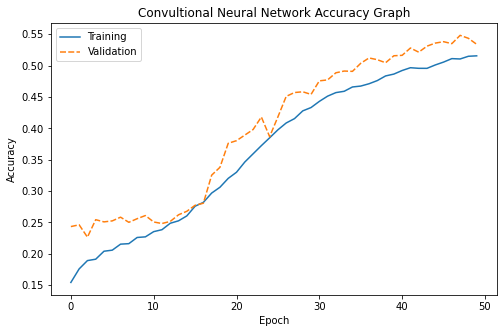

In [ ]:
plot_model_performance(CNN2_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN2.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN2.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

180/180 [==============================] - 28s 155ms/step - loss: 1.1936 - accuracy: 0.5340


Training Accuracy:	57.251107692718506
Training Loss:		1.1251643896102905

Validation Accuracy:	53.401774168014526
Validation Loss:	1.1936078071594238

Train/Validation Diff:	 3.8493335247039795


In [ ]:
CNN2.save('Deliverables/cnn2_model.h5')

## CNN-v3

In [13]:
CNN3 = Sequential()
CNN3.add(data_augmentation)
CNN3.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.1))

CNN3.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.3))

CNN3.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.3))

CNN3.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.3))

CNN3.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.2))
CNN3.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.2))
        
        
CNN3.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.2))
CNN3.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN3.add(BatchNormalization())
CNN3.add(MaxPooling2D())
CNN3.add(Dropout(0.2))

        
CNN3.add(Flatten()) # after flatten we can add dence lyer
CNN3.add(Dense(64,kernel_initializer='he_normal'))
CNN3.add(Activation('relu'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.5))


CNN3.add(Dense(64,kernel_initializer='he_normal'))
CNN3.add(Activation('relu'))
CNN3.add(BatchNormalization())
CNN3.add(Dropout(0.5))

CNN3.add(Dense(7, activation='softmax'))

CNN3.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [14]:
## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 8, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="CNN3_best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

In [2]:
CNN3_hist = CNN3.fit_generator(train_data, 
                           steps_per_epoch= 10, 
                           epochs= 100, 
                           validation_data= val_data, 
                           validation_steps= 8, 
                           callbacks=[es,mc])
'''
CNN3_hist = CNN3.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])
        '''

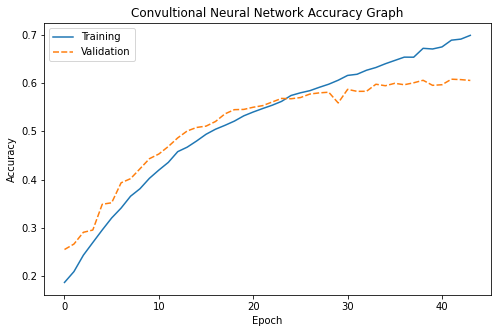

In [ ]:
plot_model_performance(CNN3_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN3.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN3.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

180/180 [==============================] - 21s 119ms/step - loss: 1.0909 - accuracy: 0.5994


Training Accuracy:	75.84705352783203
Training Loss:		0.6896095275878906

Validation Accuracy:	59.94431972503662
Validation Loss:	1.0908572673797607

Train/Validation Diff:	 15.90273380279541


In [ ]:
CNN3.save('Deliverables/cnn3_model.h5')

## CNN-v4

In [ ]:
CNN4 = Sequential()
CNN4.add(data_augmentation)
CNN4.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))

CNN4.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN4.add(MaxPooling2D())


CNN4.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN4.add(MaxPooling2D())
        
        
CNN4.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN4.add(BatchNormalization())

CNN4.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN4.add(MaxPooling2D())

        
CNN4.add(Flatten()) # after flatten we can add dence lyer
CNN4.add(Dense(1000,kernel_initializer='he_normal'))
CNN4.add(Activation('relu'))


CNN4.add(Dense(512,kernel_initializer='he_normal'))
CNN4.add(Activation('relu'))

CNN4.add(Dense(256,kernel_initializer='he_normal'))
CNN4.add(Activation('relu'))

CNN4.add(Dense(128,kernel_initializer='he_normal'))
CNN4.add(Activation('relu'))


CNN4.add(Dense(64,kernel_initializer='he_normal'))
CNN4.add(Activation('relu'))

CNN4.add(Dense(32,kernel_initializer='he_normal'))
CNN4.add(Activation('relu'))

CNN4.add(Dense(7, activation='softmax'))

CNN4.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
CNN4_hist = CNN4.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/100
718/718 [==============================] - 519s 721ms/step - loss: 1.6136 - accuracy: 0.3635 - val_loss: 1.5646 - val_accuracy: 0.3934
Epoch 2/100
718/718 [==============================] - 506s 704ms/step - loss: 1.3517 - accuracy: 0.4825 - val_loss: 1.4083 - val_accuracy: 0.4634
Epoch 3/100
718/718 [==============================] - 498s 694ms/step - loss: 1.1891 - accuracy: 0.5518 - val_loss: 1.4222 - val_accuracy: 0.4677
Epoch 4/100
718/718 [==============================] - 487s 678ms/step - loss: 1.0427 - accuracy: 0.6108 - val_loss: 1.3313 - val_accuracy: 0.5156
Epoch 5/100
718/718 [==============================] - 491s 683ms/step - loss: 0.8828 - accuracy: 0.6770 - val_loss: 1.4929 - val_accuracy: 0.5072
Epoch 6/100
718/718 [==============================] - 480s 668ms/step - loss: 0.7144 - accuracy: 0.7454 - val_loss: 2.2213 - val_accuracy: 0.4037
Epoch 7/100
718/718 [==============================] - 474s 660ms/step - loss: 0.5723 - accuracy: 0.7988 - val_loss: 2

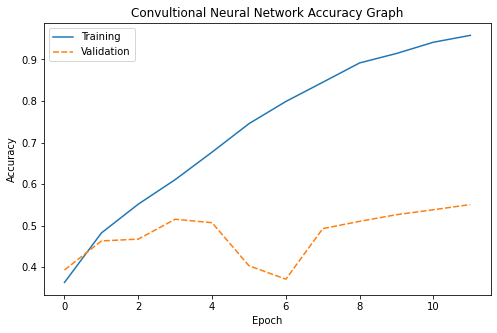

In [ ]:
plot_model_performance(CNN4_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN4.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN4.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
CNN4.save('Deliverables/cnn4_model.h5')

## CNN-v5

In [ ]:
CNN5 = Sequential()
CNN5.add(data_augmentation)
CNN5.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
CNN5.add(Dropout(0.1))

CNN5.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN5.add(Dropout(0.1))
CNN5.add(MaxPooling2D())


CNN5.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN5.add(MaxPooling2D())
        
        
CNN5.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN5.add(BatchNormalization())

CNN5.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN5.add(MaxPooling2D())

        
CNN5.add(Flatten()) # after flatten we can add dence lyer
CNN5.add(Dense(1000,kernel_initializer='he_normal'))
CNN5.add(Activation('relu'))


CNN5.add(Dense(512,kernel_initializer='he_normal'))
CNN5.add(Activation('relu'))

CNN5.add(Dense(256,kernel_initializer='he_normal'))
CNN5.add(Activation('relu'))

CNN5.add(Dense(128,kernel_initializer='he_normal'))
CNN5.add(Activation('relu'))


CNN5.add(Dense(64,kernel_initializer='he_normal'))
CNN5.add(Activation('relu'))

CNN5.add(Dense(32,kernel_initializer='he_normal'))
CNN5.add(Activation('relu'))

CNN5.add(Dense(7, activation='softmax'))

CNN5.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy']) #sparse_categorical_crossentropy'

In [ ]:
CNN5_hist = CNN5.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/100
718/718 [==============================] - 598s 831ms/step - loss: 1.6922 - accuracy: 0.3243 - val_loss: 1.6494 - val_accuracy: 0.3567
Epoch 2/100
718/718 [==============================] - 670s 933ms/step - loss: 1.4608 - accuracy: 0.4368 - val_loss: 1.4797 - val_accuracy: 0.4402
Epoch 3/100
718/718 [==============================] - 626s 871ms/step - loss: 1.2844 - accuracy: 0.5128 - val_loss: 1.3139 - val_accuracy: 0.4876
Epoch 4/100
718/718 [==============================] - 537s 748ms/step - loss: 1.1561 - accuracy: 0.5637 - val_loss: 1.2340 - val_accuracy: 0.5347
Epoch 5/100
718/718 [==============================] - 550s 766ms/step - loss: 1.0223 - accuracy: 0.6195 - val_loss: 1.3480 - val_accuracy: 0.5069
Epoch 6/100
718/718 [==============================] - 537s 748ms/step - loss: 0.8787 - accuracy: 0.6800 - val_loss: 1.5160 - val_accuracy: 0.5058
Epoch 7/100
718/718 [==============================] - 564s 786ms/step - loss: 0.7053 - accuracy: 0.7454 - val_loss: 1

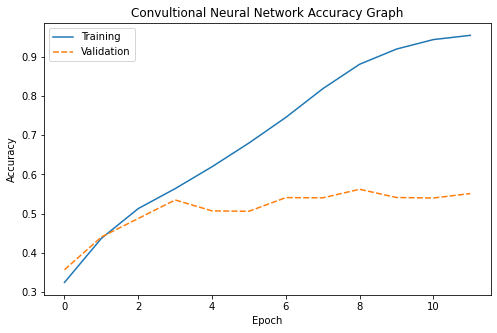

In [ ]:
plot_model_performance(CNN5_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN5.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN5.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

180/180 [==============================] - 35s 196ms/step - loss: 1.2340 - accuracy: 0.5347


Training Accuracy:	61.667102575302124
Training Loss:		1.0303975343704224

Validation Accuracy:	53.47137451171875
Validation Loss:	1.2339832782745361

Train/Validation Diff:	 8.195728063583374


In [ ]:
CNN5.save('Deliverables/cnn5_model.h5')

## CNN-v6

In [ ]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

CNN6 = Sequential()
CNN6.add(data_augmentation)
CNN6.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))

CNN6.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN6.add(MaxPooling2D())


CNN6.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN6.add(MaxPooling2D())
        
        
CNN6.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN6.add(BatchNormalization())
CNN6.add(Dropout(0.3))

CNN6.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN6.add(MaxPooling2D())
CNN6.add(Dropout(0.3))
        
CNN6.add(Flatten()) # after flatten we can add dence lyer
CNN6.add(Dense(1000,kernel_initializer='he_normal',kernel_regularizer='l1'))
CNN6.add(Activation('relu'))


CNN6.add(Dense(512,kernel_initializer='he_normal',kernel_regularizer='l1'))
CNN6.add(Activation('relu'))

CNN6.add(Dense(256,kernel_initializer='he_normal',kernel_regularizer='l1'))
CNN6.add(Activation('relu'))

CNN6.add(Dense(128,kernel_initializer='he_normal',kernel_regularizer='l1'))
CNN6.add(Activation('relu'))


CNN6.add(Dense(64,kernel_initializer='he_normal',kernel_regularizer='l1'))
CNN6.add(Activation('relu'))

CNN6.add(Dense(32,kernel_initializer='he_normal',kernel_regularizer='l1'))
CNN6.add(Activation('relu'))

CNN6.add(Dense(7, activation='softmax'))

CNN6.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
CNN6_hist = CNN6.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

## CNN-v7

In [ ]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

CNN7 = Sequential()
CNN7.add(data_augmentation)
CNN7.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))

CNN7.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN7.add(MaxPooling2D())


CNN7.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN7.add(MaxPooling2D())
        
        
CNN7.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN7.add(BatchNormalization())
CNN7.add(Dropout(0.3))

CNN7.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l1'))
CNN7.add(MaxPooling2D())
CNN7.add(Dropout(0.3))
        
CNN7.add(Flatten()) # after flatten we can add dence lyer
CNN7.add(Dense(1000,kernel_initializer='he_normal'))
CNN7.add(Activation('relu'))
CNN7.add(Dropout(0.3))

CNN7.add(Dense(512,kernel_initializer='he_normal'))
CNN7.add(Activation('relu'))

CNN7.add(Dense(256,kernel_initializer='he_normal'))
CNN7.add(Activation('relu'))

CNN7.add(Dense(128,kernel_initializer='he_normal'))
CNN7.add(Activation('relu'))


CNN7.add(Dense(64,kernel_initializer='he_normal'))
CNN7.add(Activation('relu'))

CNN7.add(Dense(32,kernel_initializer='he_normal'))
CNN7.add(Activation('relu'))

CNN7.add(Dense(7, activation='softmax'))

CNN7.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
CNN7_hist = CNN7.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

## CNN-v8

In [ ]:
CNN8 = Sequential()
CNN8.add(data_augmentation)
CNN8.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))

CNN8.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN8.add(MaxPooling2D())


CNN8.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN8.add(MaxPooling2D())
      
        
CNN8.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN8.add(BatchNormalization())

CNN8.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN8.add(MaxPooling2D())

        
CNN8.add(Flatten()) # after flatten we can add dence lyer
CNN8.add(Dense(128,kernel_initializer='he_normal'))
CNN8.add(Activation('relu'))
CNN8.add(Dropout(0.3))


CNN8.add(Dense(228,kernel_initializer='he_normal'))
CNN8.add(Activation('relu'))

CNN8.add(Dense(556,kernel_initializer='he_normal'))
CNN8.add(Activation('relu'))


CNN8.add(Dense(712,kernel_initializer='he_normal'))
CNN8.add(Activation('relu'))
CNN8.add(Dropout(0.3))

CNN8.add(Dense(1000,kernel_initializer='he_normal'))
CNN8.add(Activation('relu'))

CNN8.add(Dense(7, activation='softmax'))

CNN8.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
CNN8_hist = CNN8.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

## CNN-v9

In [ ]:
CNN9 = Sequential()
CNN9.add(data_augmentation)
CNN9.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))

CNN9.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
CNN9.add(BatchNormalization())
CNN9.add(MaxPooling2D())


CNN9.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
CNN9.add(MaxPooling2D())
        
        
CNN9.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN9.add(BatchNormalization())

CNN9.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
CNN9.add(MaxPooling2D())

        
CNN9.add(Flatten()) # after flatten we can add dence lyer
CNN9.add(Dense(400,kernel_initializer='he_normal'))
CNN9.add(Activation('relu'))
CNN9.add(BatchNormalization())


CNN9.add(Dense(512,kernel_initializer='he_normal'))
CNN9.add(Activation('relu'))

CNN9.add(Dense(256,kernel_initializer='he_normal'))
CNN9.add(Activation('relu'))
CNN9.add(BatchNormalization())


CNN9.add(Dense(600,kernel_initializer='he_normal'))
CNN9.add(Activation('relu'))
CNN9.add(Dropout(0.3))



CNN9.add(Dense(800,kernel_initializer='he_normal'))
CNN9.add(Activation('relu'))
CNN9.add(BatchNormalization())
CNN9.add(Dropout(0.5))


CNN9.add(Dense(1000,kernel_initializer='he_normal'))
CNN9.add(Activation('relu'))
CNN9.add(Dropout(0.5))


CNN9.add(Dense(7, activation='softmax'))

CNN9.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [ ]:
CNN9_hist = CNN9.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

## CNN-v10

In [ ]:
CNN10 = Sequential()

CNN10.add(data_augmentation)
CNN10.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN10.add(BatchNormalization())

CNN10.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN10.add(MaxPooling2D())
CNN10.add(BatchNormalization())


CNN10.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN10.add(MaxPooling2D())
CNN10.add(BatchNormalization())

             
CNN10.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN10.add(BatchNormalization())
CNN10.add(BatchNormalization())


CNN10.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN10.add(MaxPooling2D())
CNN10.add(BatchNormalization())

        
CNN10.add(Flatten()) # after flatten we can add dence lyer
CNN10.add(Dense(1000))
CNN10.add(Activation('relu'))
CNN10.add(BatchNormalization())



CNN10.add(Dense(512)) # CNN9.add(Dense(512,kernel_initializer='he_normal'))
CNN10.add(Activation('relu'))
CNN10.add(BatchNormalization())


CNN10.add(Dense(256))
CNN10.add(Activation('relu'))
CNN10.add(BatchNormalization())


CNN10.add(Dense(128))
CNN10.add(Activation('relu'))
CNN10.add(BatchNormalization())

CNN10.add(Dense(64))
CNN10.add(Activation('relu'))
CNN10.add(BatchNormalization())

CNN10.add(Dense(32))
CNN10.add(Activation('relu'))
CNN10.add(BatchNormalization())

CNN10.add(Dense(7, activation='softmax'))

CNN10.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_opt, metrics=['accuracy'])

In [ ]:
CNN10_hist = CNN10.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/100
718/718 [==============================] - 587s 814ms/step - loss: 7.6680 - accuracy: 0.2073 - val_loss: 7.4531 - val_accuracy: 0.2459
Epoch 2/100
718/718 [==============================] - 424s 590ms/step - loss: 7.1980 - accuracy: 0.3032 - val_loss: 7.0991 - val_accuracy: 0.3195
Epoch 3/100
718/718 [==============================] - 447s 622ms/step - loss: 6.8264 - accuracy: 0.4028 - val_loss: 6.8874 - val_accuracy: 0.3564
Epoch 4/100
718/718 [==============================] - 430s 599ms/step - loss: 6.4620 - accuracy: 0.4996 - val_loss: 6.7253 - val_accuracy: 0.3706
Epoch 5/100
718/718 [==============================] - 433s 602ms/step - loss: 6.1081 - accuracy: 0.6019 - val_loss: 6.5715 - val_accuracy: 0.3845
Epoch 6/100
718/718 [==============================] - 439s 611ms/step - loss: 5.7709 - accuracy: 0.7003 - val_loss: 6.4568 - val_accuracy: 0.3856
Epoch 7/100
718/718 [==============================] - 443s 617ms/step - loss: 5.4540 - accuracy: 0.7880 - val_loss: 6

718/718 [==============================] - 403s 561ms/step - loss: 1.1548 - accuracy: 1.0000 - val_loss: 3.7644 - val_accuracy: 0.3792
Epoch 57/100
718/718 [==============================] - 400s 557ms/step - loss: 1.1222 - accuracy: 1.0000 - val_loss: 3.7397 - val_accuracy: 0.3790
Epoch 58/100
718/718 [==============================] - 399s 556ms/step - loss: 1.0904 - accuracy: 1.0000 - val_loss: 3.7137 - val_accuracy: 0.3793
Epoch 59/100
718/718 [==============================] - 400s 557ms/step - loss: 1.0595 - accuracy: 1.0000 - val_loss: 3.6913 - val_accuracy: 0.3797
Epoch 60/100
718/718 [==============================] - 402s 559ms/step - loss: 1.0295 - accuracy: 1.0000 - val_loss: 3.6710 - val_accuracy: 0.3795
Epoch 61/100
718/718 [==============================] - 402s 560ms/step - loss: 1.0004 - accuracy: 1.0000 - val_loss: 3.6497 - val_accuracy: 0.3805
Epoch 62/100
718/718 [==============================] - 400s 557ms/step - loss: 0.9721 - accuracy: 1.0000 - val_loss: 3.6251 

In [ ]:
plot_model_performance(CNN10_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN10.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN10.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
CNN10.save('Deliverables/cnn10_model.h5')

## CNN-v11 

In [ ]:
CNN11 = Sequential()

CNN11.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN11.add(MaxPooling2D())
CNN11.add(BatchNormalization())


CNN11.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN11.add(MaxPooling2D())
CNN11.add(BatchNormalization())

             
CNN11.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',kernel_regularizer='l2'))
CNN11.add(BatchNormalization())
CNN11.add(BatchNormalization())

     
CNN11.add(Flatten()) # after flatten we can add dence layer
CNN11.add(Dense(512))
CNN11.add(Activation('relu'))
CNN11.add(BatchNormalization())


CNN11.add(Dense(256)) # CNN9.add(Dense(512,kernel_initializer='he_normal'))
CNN11.add(Activation('relu'))
CNN11.add(BatchNormalization())


CNN11.add(Dense(128))
CNN11.add(Activation('relu'))
CNN11.add(BatchNormalization())

CNN11.add(Dense(64))
CNN11.add(Activation('relu'))
CNN11.add(BatchNormalization())

CNN11.add(Dense(32))
CNN11.add(Activation('relu'))
CNN11.add(BatchNormalization())

CNN11.add(Dense(7, activation='softmax'))

CNN11.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
CNN11_hist = CNN11.fit(train_data, epochs=100, validation_data=valid_data, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

In [ ]:
plot_model_performance(CNN11_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN11.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN11.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
CNN11.save('Deliverables/cnn11_model.h5')

#Transfer Learning

##  DenseNet

In [ ]:
# Freeze layers
dense_net = DenseNet169(weights='imagenet', include_top=False, input_shape=None)

for layer in dense_net.layers:
    layer.trainable = False

In [ ]:
CNN_dense_transfer = Sequential()
CNN_dense_transfer.add(dense_net)
CNN_dense_transfer.add(GlobalAveragePooling2D())

CNN_dense_transfer.add(Dense(256 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())
CNN_dense_transfer.add(Dense(128 , activation ='relu'))
CNN_dense_transfer.add(Dense(60 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())

CNN_dense_transfer.add(Dense(7, activation='softmax'))

CNN_dense_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_opt, metrics = ['accuracy'])
CNN_dense_transfer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d_1   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               426240    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_3 (Batc  (None, 128)             

In [ ]:
CNN_dense_transfer_hist = CNN_dense_transfer.fit(train_data, epochs=10, validation_data=valid_data, verbose=1)

Epoch 1/10
718/718 [==============================] - ETA: 0s - loss: 2.0322 - accuracy: 0.2231

In [ ]:
plot_model_performance(CNN_dense_transfer_hist, 'Convultional Neural Network with DenseNet Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = CNN_dense_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_dense_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

## VGG16-v1

In [ ]:

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
for layer in vgg.layers:
    layer.trainable = False


In [ ]:
vgg_16_transfer = Sequential()

vgg_16_transfer.add(data_augmentation)

vgg_16_transfer.add(vgg)

#vgg_16_transfer.add(GlobalAveragePooling2D()) # try it using max Pooling2

vgg_16_transfer.add(Dense(125 , activation ='relu'))
vgg_16_transfer.add(BatchNormalization())
vgg_16_transfer.add(Dense(25 , activation ='relu'))
vgg_16_transfer.add(BatchNormalization())

#vgg_16_transfer.add(GlobalMaxPooling2D())
vgg_16_transfer.add(Dense(7, activation='softmax'))

vgg_16_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
vgg_16_transfer_hist = vgg_16_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

Epoch 1/15
718/718 [==============================] - 312s 433ms/step - loss: 1.7116 - accuracy: 0.1878 - val_loss: 1.6001 - val_accuracy: 0.2002
Epoch 2/15
718/718 [==============================] - 327s 455ms/step - loss: 1.5514 - accuracy: 0.1908 - val_loss: 1.5751 - val_accuracy: 0.2057
Epoch 3/15
718/718 [==============================] - 328s 457ms/step - loss: 1.5068 - accuracy: 0.1897 - val_loss: 1.5592 - val_accuracy: 0.1979
Epoch 4/15
718/718 [==============================] - 331s 461ms/step - loss: 1.4751 - accuracy: 0.1893 - val_loss: 1.5880 - val_accuracy: 0.1955
Epoch 5/15
718/718 [==============================] - 329s 458ms/step - loss: 1.4486 - accuracy: 0.1887 - val_loss: 1.6040 - val_accuracy: 0.1797
Epoch 6/15
718/718 [==============================] - 328s 457ms/step - loss: 1.4263 - accuracy: 0.1885 - val_loss: 1.6026 - val_accuracy: 0.1796
Epoch 7/15
718/718 [==============================] - 330s 460ms/step - loss: 1.4020 - accuracy: 0.1883 - val_loss: 1.6002 -

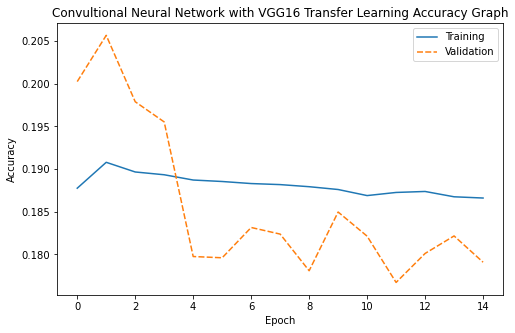

In [ ]:
plot_model_performance(vgg_16_transfer, 'Convultional Neural Network with VGG16 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = vgg_16_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = vgg_16_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

## VGG16-v2

In [ ]:
'''
from keras.applications.vgg16 import VGG16 
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
for layer in vgg.layers:
    layer.trainable = False
    
'''

In [ ]:
'''
vgg_model = Sequential([InputLayer (input_shape=(48,48,1)),
                         vgg,
                         Conv2D (filters=20,kernel_size=3, activation='tanh',padding='valid'),
                         MaxPooling2D(),
                         
                         Flatten(),
                         Dense (125, activation='tanh'),
                         Dropout (rate=.25, seed=123),
                         
                         Dense (25, activation='tanh'),
                         Dropout (rate=.25, seed=123),
                         
                         Dense (7, activation='softmax') ])


vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
                   
vgg_model.summary()   
'''

"\nvgg_model = Sequential([InputLayer (input_shape=(48,48,1)),\n                         vgg,\n                         Conv2D (filters=20,kernel_size=3, activation='tanh',padding='valid'),\n                         MaxPooling2D(),\n                         \n                         Flatten(),\n                         Dense (125, activation='tanh'),\n                         Dropout (rate=.25, seed=123),\n                         \n                         Dense (25, activation='tanh'),\n                         Dropout (rate=.25, seed=123),\n                         \n                         Dense (7, activation='softmax') ])\n\n\nvgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])\n                   \nvgg_model.summary()   \n"

## VGG19

In [ ]:
vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg_19.layers[:-2]:
    layer.trainable = False

80150528/80134624 [==============================] - 183s 2us/step


In [ ]:
vgg_19_transfer = Sequential()
vgg_19_transfer.add(Dropout(0.2)) # dropout
vgg_19_transfer.add(data_augmentation)

vgg_19_transfer.add(vgg_19)

vgg_19_transfer.add(GlobalAveragePooling2D())

vgg_19_transfer.add(Dense(200 , activation ='relu', kernel_regularizer=regularizers.l2(0.01))) # , kernel_regularizer=regularizers.l2(0.01)
vgg_19_transfer.add(BatchNormalization()) 
vgg_19_transfer.add(Dense(100 , activation ='relu'))

vgg_19_transfer.add(BatchNormalization())
vgg_19_transfer.add(Dense(50 , activation ='relu'))
vgg_19_transfer.add(BatchNormalization())
vgg_19_transfer.add(Dense(7, activation='softmax'))

vgg_19_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
vgg_19_transfer_hist = vgg_19_transfer.fit(train_data, epochs=10, validation_data=valid_data, verbose=1,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ])

'''
,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
'''

Epoch 1/10
718/718 [==============================] - 501s 695ms/step - loss: 2.4124 - accuracy: 0.2765 - val_loss: 2.0448 - val_accuracy: 0.2659 - lr: 0.0010
Epoch 2/10
718/718 [==============================] - 518s 722ms/step - loss: 1.7967 - accuracy: 0.3084 - val_loss: 1.8306 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 3/10
718/718 [==============================] - 579s 806ms/step - loss: 1.7245 - accuracy: 0.3189 - val_loss: 1.7975 - val_accuracy: 0.2591 - lr: 0.0010
Epoch 4/10
718/718 [==============================] - 777s 1s/step - loss: 1.7031 - accuracy: 0.3268 - val_loss: 1.7463 - val_accuracy: 0.3082 - lr: 0.0010
Epoch 5/10
718/718 [==============================] - 638s 889ms/step - loss: 1.6955 - accuracy: 0.3274 - val_loss: 1.9954 - val_accuracy: 0.2467 - lr: 0.0010
Epoch 6/10
718/718 [==============================] - 760s 1s/step - loss: 1.6900 - accuracy: 0.3354 - val_loss: 2.1755 - val_accuracy: 0.1397 - lr: 0.0010
Epoch 7/10
718/718 [==============================] 

'\n,callbacks=[\n        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),\n        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),\n    ]\n'

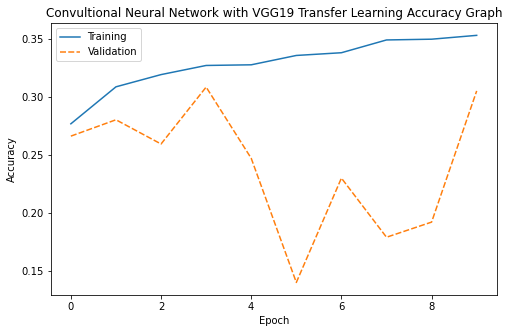

In [ ]:
plot_model_performance(vgg_19_transfer_hist, 'Convultional Neural Network with VGG19 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = vgg_19_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = vgg_19_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

180/180 [==============================] - 96s 534ms/step - loss: 1.7468 - accuracy: 0.3049


Training Accuracy:	32.183608412742615
Training Loss:		1.7213045358657837

Validation Accuracy:	30.485472083091736
Validation Loss:	1.7467519044876099

Train/Validation Diff:	 1.698136329650879


In [ ]:
vgg_19_transfer.save('Deliverables/vgg_19_transfer.h5')

In [ ]:
#pickle.dump(vgg_19_transfer, open('vgg_19_transfer.pkl', 'wb'))

## ResNet50-v1

In [2]:
resnet_50 = ResNet50(weights='imagenet', include_top=False, input_shape=None)

for layer in resnet_50.layers[:-1]:
    layer.trainable = False

In [2]:
resnet_transfer = Sequential()

resnet_transfer.add(data_augmentation)

resnet_transfer.add(resnet_50)

resnet_transfer.add(GlobalAveragePooling2D())

resnet_transfer.add(Dense(200 , activation ='relu'))
resnet_transfer.add(BatchNormalization())
resnet_transfer.add(Dense(100 , activation ='relu'))
resnet_transfer.add(BatchNormalization())
resnet_transfer.add(Dense(100 , activation ='relu'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Dense(7 , activation='softmax'))

resnet_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [2]:
resnet_transfer_hist = resnet_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

In [2]:
plot_model_performance(resnet_transfer_hist, 'Convultional Neural Network with ResNet50 Transfer Learning', save=True)

In [2]:
train_loss, train_acc = resnet_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = resnet_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [2]:
resnet_transfer.save('Deliverables/resnet_transfer.h5')

## ResNet50-v2

In [ ]:
resnet_transfer = Sequential()

resnet_transfer.add(data_augmentation)

resnet_transfer.add(resnet_50)


resnet_transfer.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Flatten()) # after flatten we can add dence lyer


resnet_transfer.add(Dense(200 , activation ='relu'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Dense(100 , activation ='relu'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Dense(50 , activation ='relu'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Dense(7 , activation='softmax'))

resnet_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
resnet_transfer_hist = resnet_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

## MobileNet-v1

In [ ]:
base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=7 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

In [ ]:
## having early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list 
call_back = [es, mc]

In [ ]:
hist = model.fit_generator(train_data, 
                           steps_per_epoch= 10, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 8, 
                           callbacks=[es,mc])

## MobileNet-v2

In [ ]:
# Working with pre trained model 
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False

x =Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(base_model.output)
x = Flatten()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dense(units=7 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

In [ ]:
hist = model.fit_generator(train_data, 
                           steps_per_epoch= 10, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 8, 
                           callbacks=[es,mc])

# Chosen Model

From all the models that were testted above, the best model in terms of highest validation accuracy, is the `CNN-v3` model